In [1]:
from torch_fftconv import fft_conv1d, FFTConv1d
import numpy as np
import torch
from torch import nn
from torch.autograd import grad
import selene_sdk
import pandas as pd
from matplotlib import pyplot as plt
class simpleNet(nn.Module):
    def __init__(self):

        super(simpleNet, self).__init__()
        self.conv = nn.Conv1d(4,  10, kernel_size=51, padding=25)

        self.conv_inr = nn.Conv1d(4,  10, kernel_size=15, padding=7)
        self.conv_sim = nn.Conv1d(4,  32, kernel_size=3, padding=1)

        self.activation = nn.Softplus()
        self.softplus = nn.Softplus()

        self.deconv = FFTConv1d(10*2,  10, kernel_size=601, padding=300)
        self.deconv_sim = FFTConv1d(64,  10, kernel_size=601, padding=300)
        self.deconv_inr = nn.ConvTranspose1d(20,  10, kernel_size=15, padding=7)

        self.scaler = nn.Parameter(torch.ones(1))
        self.scaler2 = nn.Parameter(torch.ones(1))


    def forward(self, x):
        y = torch.cat([self.conv(x), self.conv(x.flip([1,2])).flip([2])], 1)
        y_sim = torch.cat([self.conv_sim(x), self.conv_sim(x.flip([1,2])).flip([2])], 1)
        y_inr = torch.cat([self.conv_inr(x), self.conv_inr(x.flip([1,2])).flip([2])], 1)

        yact = self.activation(y )
        y_sim_act = self.activation(y_sim) #* y_sim
        y_inr_act = self.activation(y_inr)

        y_pred = self.softplus(self.deconv(yact)+self.deconv_inr(y_inr_act)+self.deconv_sim(y_sim_act))
        return y_pred
    
net = simpleNet()
net.load_state_dict(torch.load('./resources/puffin.pth'), strict=False)
net.cuda()
genome = selene_sdk.sequences.Genome(
                input_path='./resources/Homo_sapiens.GRCh38.dna.primary_assembly.fa',
                blacklist_regions= 'hg38')

tsses  = pd.read_table('./resources/FANTOM_CAT.lv3_robust.tss.sortedby_fantomcage.hg38.v5.tsv', sep='\t')


In [2]:
tri_list = []
for a in ['A','C','G','T']:
    for b in ['A','C','G','T']:
        for c in ['A','C','G','T']:
            tri_list.append(a+b+c)

In [ ]:
tri_layer = nn.Conv1d(in_channels=4, out_channels=64, kernel_size=(3), padding = 1)
tri_layer.bias.data.fill_(0)
        
for wi, tri_seq in enumerate(tri_list):
    seq = genome.sequence_to_encoding(tri_seq)
    w = torch.from_numpy(seq.T)
    tri_layer.weight.data[wi,:,:] = w


distr_tri = np.zeros((64, 2000))
for tssi in range(40000):
    chrm = tsses['chr'].values[tssi]
    pos = tsses['TSS'].values[tssi]
    strand = tsses['strand'].values[tssi]
    if strand == '-':
        offset = 1
    else:
        offset = 0
    tss_seq = genome.get_encoding_from_coords(chrm, pos-1000+offset, pos+1000+offset, strand)
    tss_seq_torch = torch.from_numpy(tss_seq).T[None, :,:]
    output = tri_layer(tss_seq_torch)
    conv_tss = output.cpu().detach().numpy()
    conv_tss = conv_tss[0,:,:]
    tri_tss_pos = (conv_tss==3).astype(int)
    distr_tri += tri_tss_pos
distr_tri = distr_tri/40000

In [ ]:
np.save(arr=distr_tri, file='./data/distr_tri.npy')

In [3]:
distr_tri = np.load('./data/distr_tri.npy')

In [13]:
%load_ext rpy2.ipython

In [15]:
%%R 
require(scales)
theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(1, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}
scale_fill_Publication <- function(...){
      discrete_scale("fill","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}
scale_colour_Publication <- function(...){
      discrete_scale("colour","Publication",manual_pal(values = c("#386cb0","#fdb462","#7fc97f","#ef3b2c","#662506","#a6cee3","#fb9a99","#984ea3","#ffff33")), ...)

}

R[write to console]: Loading required package: scales



R[write to console]: Saving 15 x 15 in image



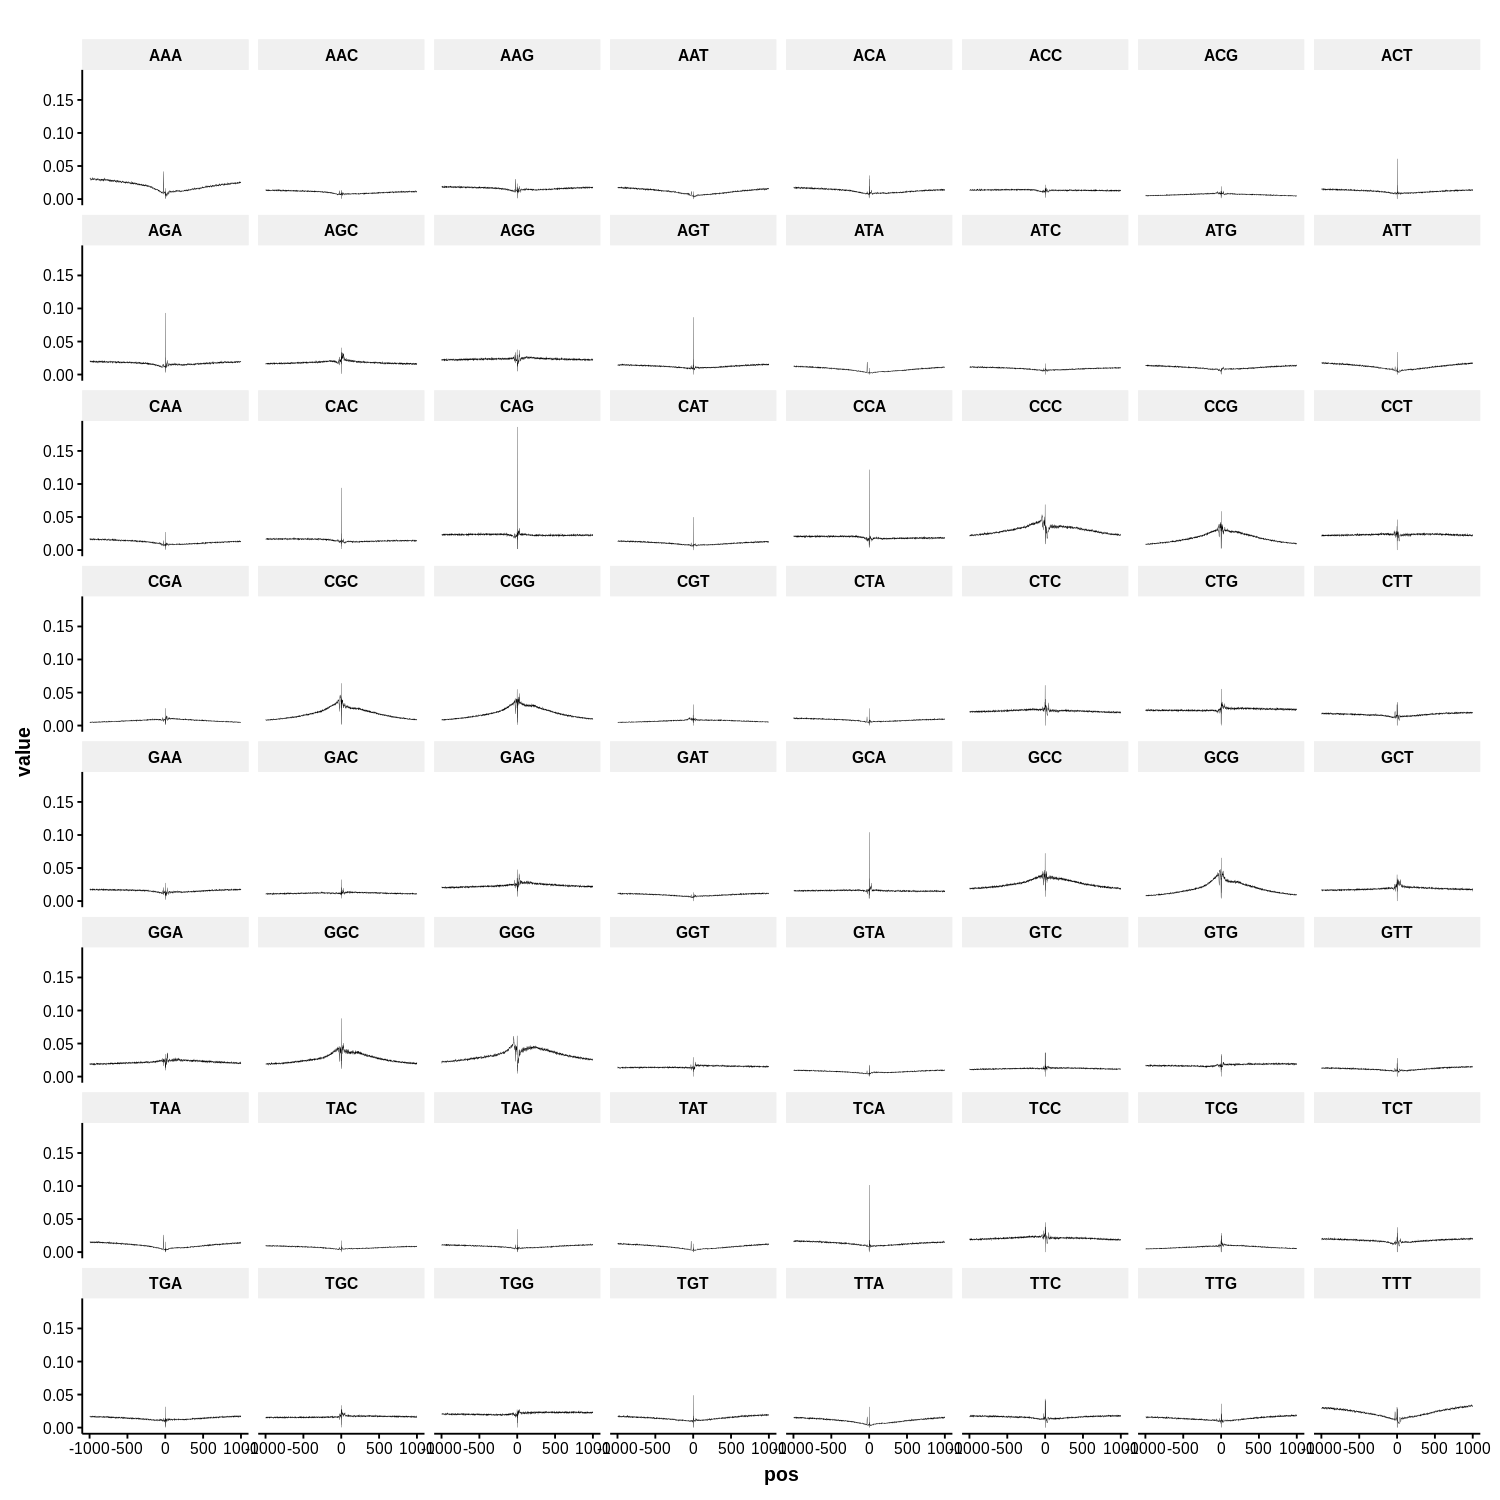

In [ ]:
%%R -i tri_list,distr_tri  -w 15 -h 15 --unit in --res 100
require(ggplot2)
require(data.table)
plotdata = data.frame(distr_tri)
plotdata$tri = unlist(tri_list)
plotdata = melt(plotdata,id='tri')
plotdata$pos = as.numeric(gsub('X','',as.character(plotdata$variable)))
plotdata=data.table(plotdata)
p = ggplot(plotdata[!(pos %in% c(1, 2000))][,pos:=pos-999,])+
    geom_line(aes(x=pos, y=value),size=I(0.1))+facet_wrap(~tri)+theme_Publication()
ggsave('./figures/tri_dist.pdf', device=cairo_pdf)
p

In [4]:
tri_dic = {}
for tri in tri_list:
    tri_dic[tri] = ''

In [5]:
import seaborn


dweight_sim = net.deconv_sim.weight.cpu().detach().numpy()
net.cuda()
targeti=0


net.cuda()



for key in tri_dic.keys():        
        seq = key
        sempty_seq = 299*'N' 
        seq = sempty_seq+seq+sempty_seq

        seq = genome.sequence_to_encoding(seq)


        preact_sim =  torch.cat([net.conv_sim(torch.FloatTensor(seq)[None,:,:].transpose(1,2).cuda()), \
                           net.conv_sim(torch.FloatTensor(seq)[None,:,:].transpose(1,2).flip([1,2]).cuda()).flip([2])], 1)



        postact_sim = net.activation(preact_sim)
        postact_sim = postact_sim 
        postact_sim[:,:,:300] = 0
        postact_sim[:,:,300+1:] = 0

        effects_sim = net.deconv_sim(postact_sim).detach().cpu().numpy()[0,:,:]

        tri_dic[key] = effects_sim
        
        

In [6]:

tri_effects = []
for tri_i, tri in enumerate(tri_list):
    effect = tri_dic[tri][0,:] #0-fantom cage
    tri_effects.append(effect)

tri_effects = np.array(tri_effects)
tri_effects_raw = tri_effects.copy()
tri_effects = tri_effects - tri_effects.mean(axis=0, keepdims=True)


In [7]:
mono_baselines = {}
for a in ['A','C','G','T']:
        
    mono_inds_left = []
    for i, tri in enumerate(tri_list):
        if a == tri[0]:
            mono_inds_left.append(i)
    mono_inds_mid = []
    for i, tri in enumerate(tri_list):
        if a == tri[1]:
            mono_inds_mid.append(i)
    mono_inds_right = []
    for i, tri in enumerate(tri_list):
        if a == tri[2]:
            mono_inds_right.append(i)
    mono_baselines[a] = (tri_effects[mono_inds_left,:-2].mean(axis=0) + tri_effects[mono_inds_mid,1:-1].mean(axis=0) + tri_effects[mono_inds_right,2:].mean(axis=0))/3
    


In [8]:
#normalize by mononucleotide effects

for it in range(10):
    for a in ['A','C','G','T']:
        mono_inds = []
        for i, tri in enumerate(tri_list):
            if a in tri:
                mono_inds.append(i)
        print(a)
#         plt.plot(tri_effects[np.array(mono_inds),:].mean(axis=0))
#         plt.show()


        mono_inds_left = []
        for i, tri in enumerate(tri_list):
            if a == tri[0]:
                mono_inds_left.append(i)
        mono_inds_mid = []
        for i, tri in enumerate(tri_list):
            if a == tri[1]:
                mono_inds_mid.append(i)
        mono_inds_right = []
        for i, tri in enumerate(tri_list):
            if a == tri[2]:
                mono_inds_right.append(i)

        tri_effects[mono_inds_left,:-2] = tri_effects[mono_inds_left,:-2] + (mono_baselines[a] - tri_effects[mono_inds_left,:-2].mean(0))[None,:]
        tri_effects[mono_inds_mid,1:-1] = tri_effects[mono_inds_mid,1:-1] + (mono_baselines[a] - tri_effects[mono_inds_mid,1:-1].mean(0))[None,:]
        tri_effects[mono_inds_right,2:] = tri_effects[mono_inds_right,2:] + (mono_baselines[a] - tri_effects[mono_inds_right,2:].mean(0))[None,:]


A
C
G
T
A
C
G
T
A
C
G
T
A
C
G
T
A
C
G
T
A
C
G
T
A
C
G
T
A
C
G
T
A
C
G
T
A
C
G
T


In [9]:
di_baselines = {}
for a in ['A','C','G','T']:
        
    di_inds_lefts = []
    for b in ['A','C','G','T']:
        di_ind = []
        for i, tri in enumerate(tri_list):
            if a+b == tri[:2]:
                di_ind.append(i)
        di_inds_lefts.append(di_ind)
        
    di_inds_rights = []
    for b in ['A','C','G','T']:
        di_ind = []
        for i, tri in enumerate(tri_list):
            if a+b == tri[-2:]:
                di_ind.append(i)
        di_inds_rights.append(di_ind)
    
    for i, b in enumerate(['A','C','G','T']):
        di_baselines[a+b] = (tri_effects[di_inds_lefts[i],:-1].mean(axis=0) + tri_effects[di_inds_rights[i],1:].mean(axis=0))/2
  


In [10]:
#normalize by dinucleotide effects

for it in range(10):
    for a in ['A','C','G','T']:
        for b in ['A','C','G','T']:
            di_ind = []
            for i, tri in enumerate(tri_list):
                if a+b in tri:
                    di_ind.append(i)
            print(a+b)
            #tri_effects[np.array(di_inds),:] = tri_effects[np.array(di_inds),:] - tri_effects.mean(axis=0, keepdims=True)

#             plt.plot(tri_effects[np.array(di_ind),:].sum(axis=0))
#             plt.show()

            di_inds_left = []
            for i, tri in enumerate(tri_list):
                if a+b == tri[:2]:
                    di_inds_left.append(i)

            di_inds_right = []
            for i, tri in enumerate(tri_list):
                if a+b == tri[-2:]:
                    di_inds_right.append(i)

            tri_effects[di_inds_left,:-1] = tri_effects[di_inds_left,:-1] + (di_baselines[a+b] - tri_effects[di_inds_left,:-1].mean(0))[None,:]
            tri_effects[di_inds_right,1:] = tri_effects[di_inds_right,1:] + (di_baselines[a+b] - tri_effects[di_inds_right,1:].mean(0))[None,:]

            di_ind = []
            for i, tri in enumerate(tri_list):
                if a+b in tri:
                    di_ind.append(i)
            print(a+b)


AA
AA
AC
AC
AG
AG
AT
AT
CA
CA
CC
CC
CG
CG
CT
CT
GA
GA
GC
GC
GG
GG
GT
GT
TA
TA
TC
TC
TG
TG
TT
TT
AA
AA
AC
AC
AG
AG
AT
AT
CA
CA
CC
CC
CG
CG
CT
CT
GA
GA
GC
GC
GG
GG
GT
GT
TA
TA
TC
TC
TG
TG
TT
TT
AA
AA
AC
AC
AG
AG
AT
AT
CA
CA
CC
CC
CG
CG
CT
CT
GA
GA
GC
GC
GG
GG
GT
GT
TA
TA
TC
TC
TG
TG
TT
TT
AA
AA
AC
AC
AG
AG
AT
AT
CA
CA
CC
CC
CG
CG
CT
CT
GA
GA
GC
GC
GG
GG
GT
GT
TA
TA
TC
TC
TG
TG
TT
TT
AA
AA
AC
AC
AG
AG
AT
AT
CA
CA
CC
CC
CG
CG
CT
CT
GA
GA
GC
GC
GG
GG
GT
GT
TA
TA
TC
TC
TG
TG
TT
TT
AA
AA
AC
AC
AG
AG
AT
AT
CA
CA
CC
CC
CG
CG
CT
CT
GA
GA
GC
GC
GG
GG
GT
GT
TA
TA
TC
TC
TG
TG
TT
TT
AA
AA
AC
AC
AG
AG
AT
AT
CA
CA
CC
CC
CG
CG
CT
CT
GA
GA
GC
GC
GG
GG
GT
GT
TA
TA
TC
TC
TG
TG
TT
TT
AA
AA
AC
AC
AG
AG
AT
AT
CA
CA
CC
CC
CG
CG
CT
CT
GA
GA
GC
GC
GG
GG
GT
GT
TA
TA
TC
TC
TG
TG
TT
TT
AA
AA
AC
AC
AG
AG
AT
AT
CA
CA
CC
CC
CG
CG
CT
CT
GA
GA
GC
GC
GG
GG
GT
GT
TA
TA
TC
TC
TG
TG
TT
TT
AA
AA
AC
AC
AG
AG
AT
AT
CA
CA
CC
CC
CG
CG
CT
CT
GA
GA
GC
GC
GG
GG
GT
GT
TA
TA
TC
TC
TG
TG
TT
TT


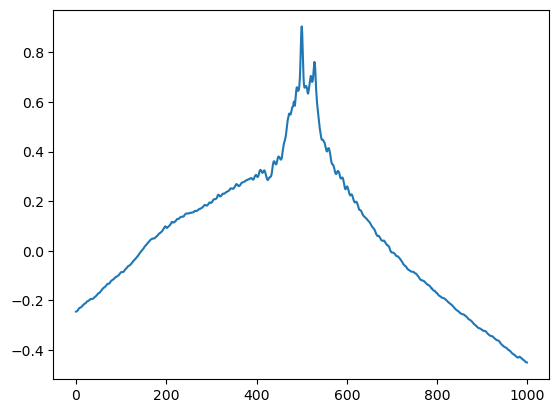

In [11]:
convolved_array = np.zeros((64, 1400))
for tri_i, tri in enumerate(tri_list):
    
    distr = distr_tri[tri_i, :]
    conv_tri = np.convolve(distr, tri_effects[tri_i], mode='same')[300:-300]
    convolved_array[tri_i,:] = conv_tri

plt.plot(convolved_array[:,200:-200].sum(0))
    

Saving 15 x 15 in image


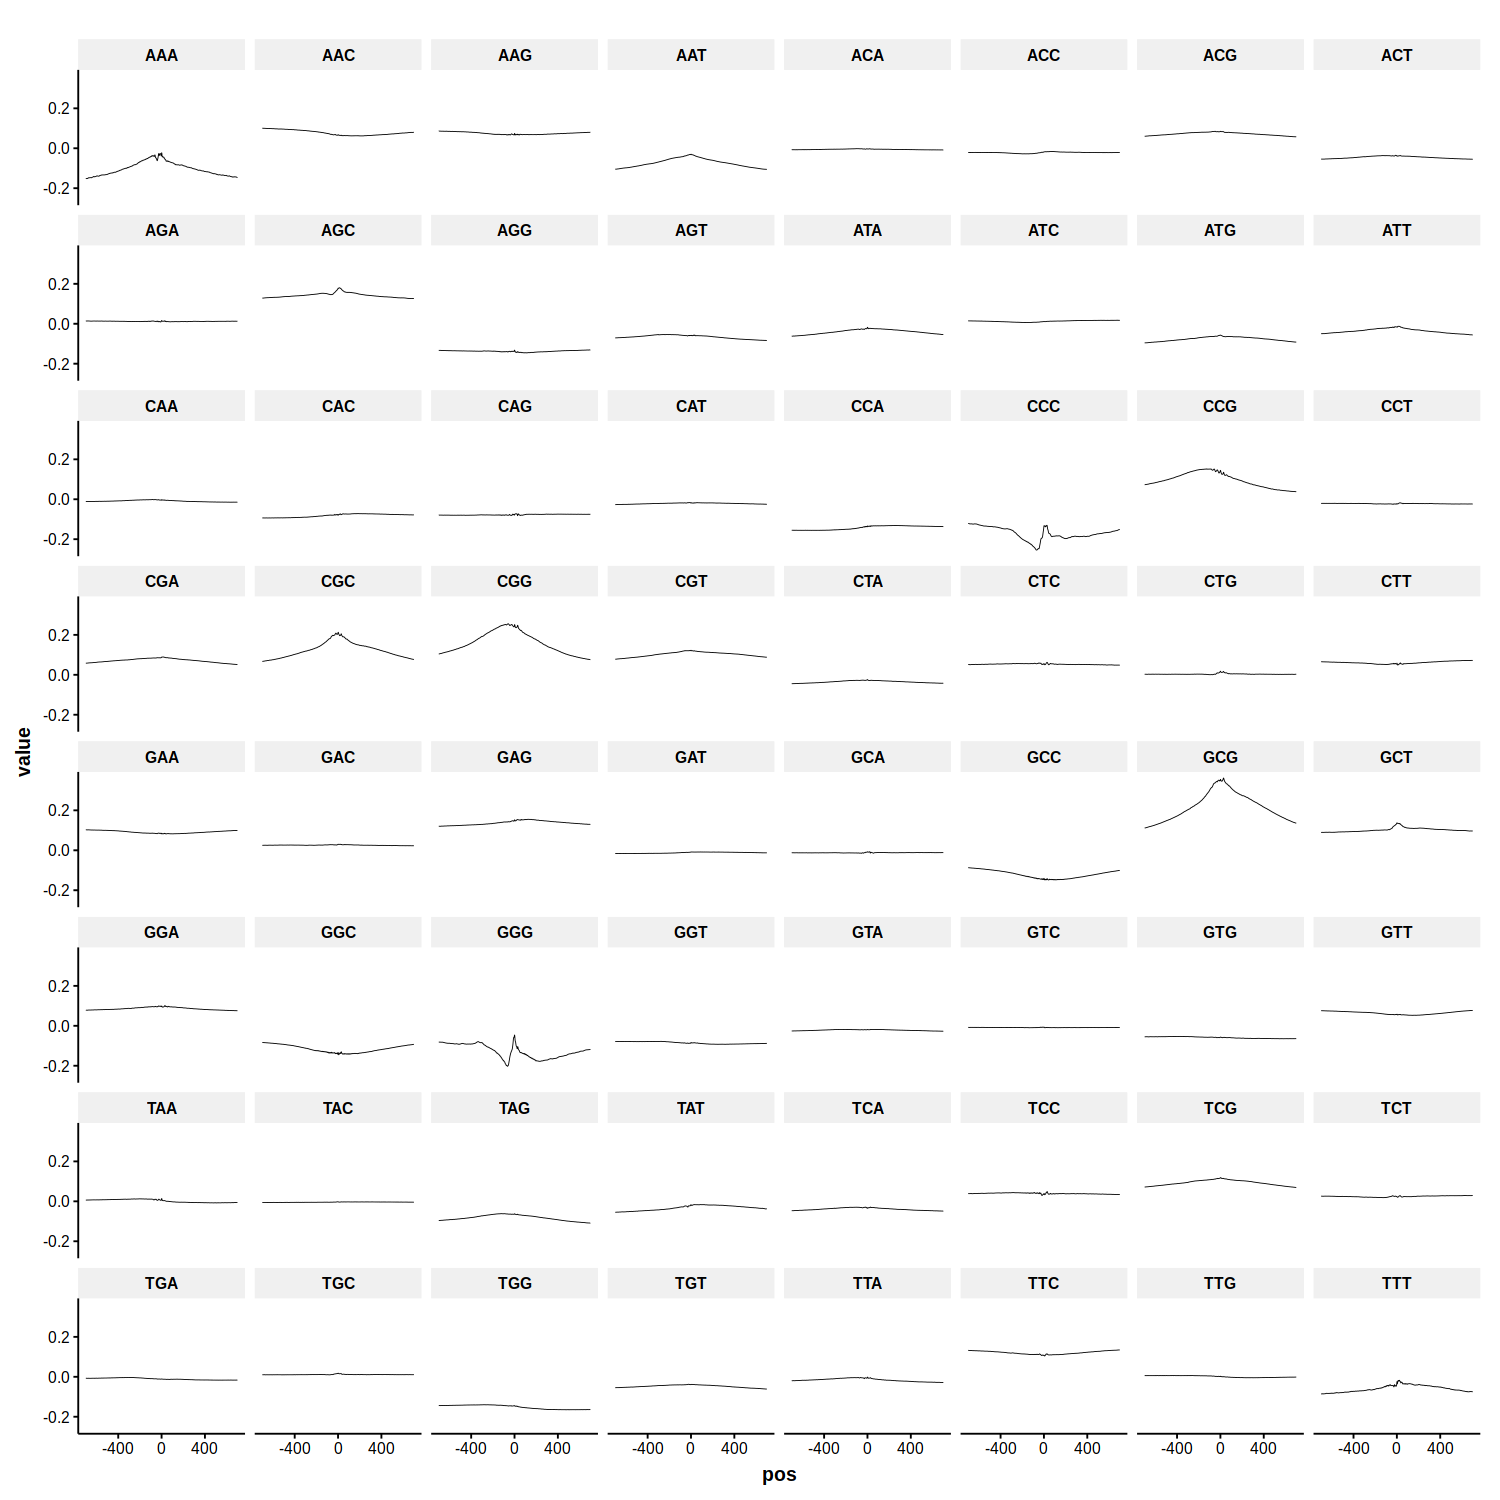

In [17]:
%%R -i tri_list,convolved_array  -w 15 -h 15 --unit in --res 100
require(ggplot2)
require(data.table)
plotdata = data.frame(convolved_array)
plotdata$tri = unlist(tri_list)
plotdata = melt(plotdata,id='tri')
plotdata$pos = as.numeric(gsub('X','',as.character(plotdata$variable)))
plotdata=data.table(plotdata)
p = ggplot(plotdata[,pos:=pos-700,])+
    geom_line(aes(x=pos, y=value),size=I(0.3))+facet_wrap(~tri)+theme_Publication()
ggsave('./figures/tri_distxeffects.pdf', device=cairo_pdf)
p

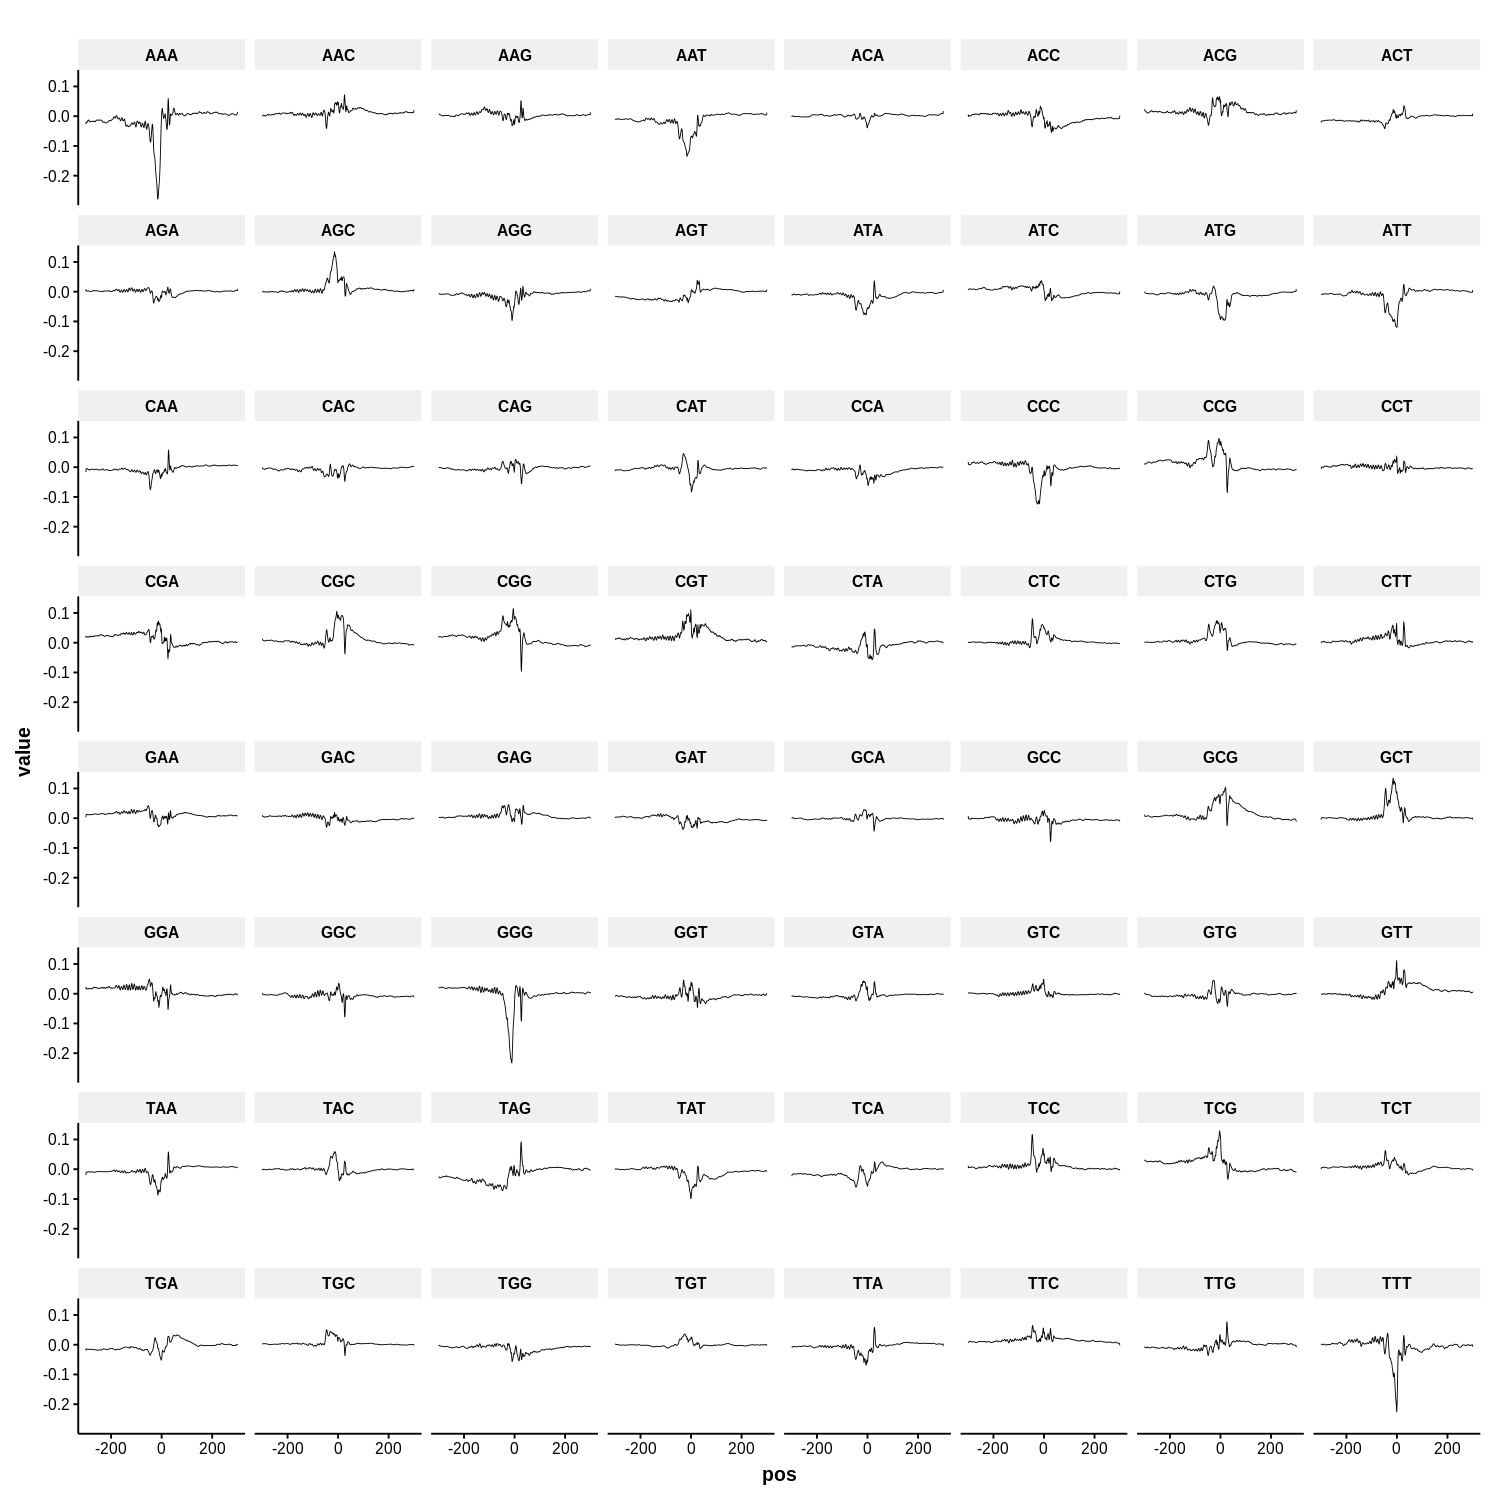

In [ ]:
%%R -i tri_list,tri_effects  -w 15 -h 15 --unit in --res 100
require(ggplot2)
require(data.table)
plotdata = data.frame(tri_effects)
plotdata$tri = unlist(tri_list)
plotdata = melt(plotdata,id='tri')
plotdata$pos = as.numeric(gsub('X','',as.character(plotdata$variable)))
plotdata=data.table(plotdata)
p = ggplot(plotdata[,pos:=pos-301,])+
    geom_line(aes(x=pos, y=value),size=I(0.3))+facet_wrap(~tri)+theme_Publication()

#ggsave('./figures/tri_effects.pdf', device=cairo_pdf)
p

In [ ]:
#convolved_array_rep0, tri_effects_rep0 and  convolved_array_rep1, tri_effects_rep1
#should be generated from two training replicates which paths are in the commented out code in 
#model loading block

R[write to console]: Saving 15 x 15 in image



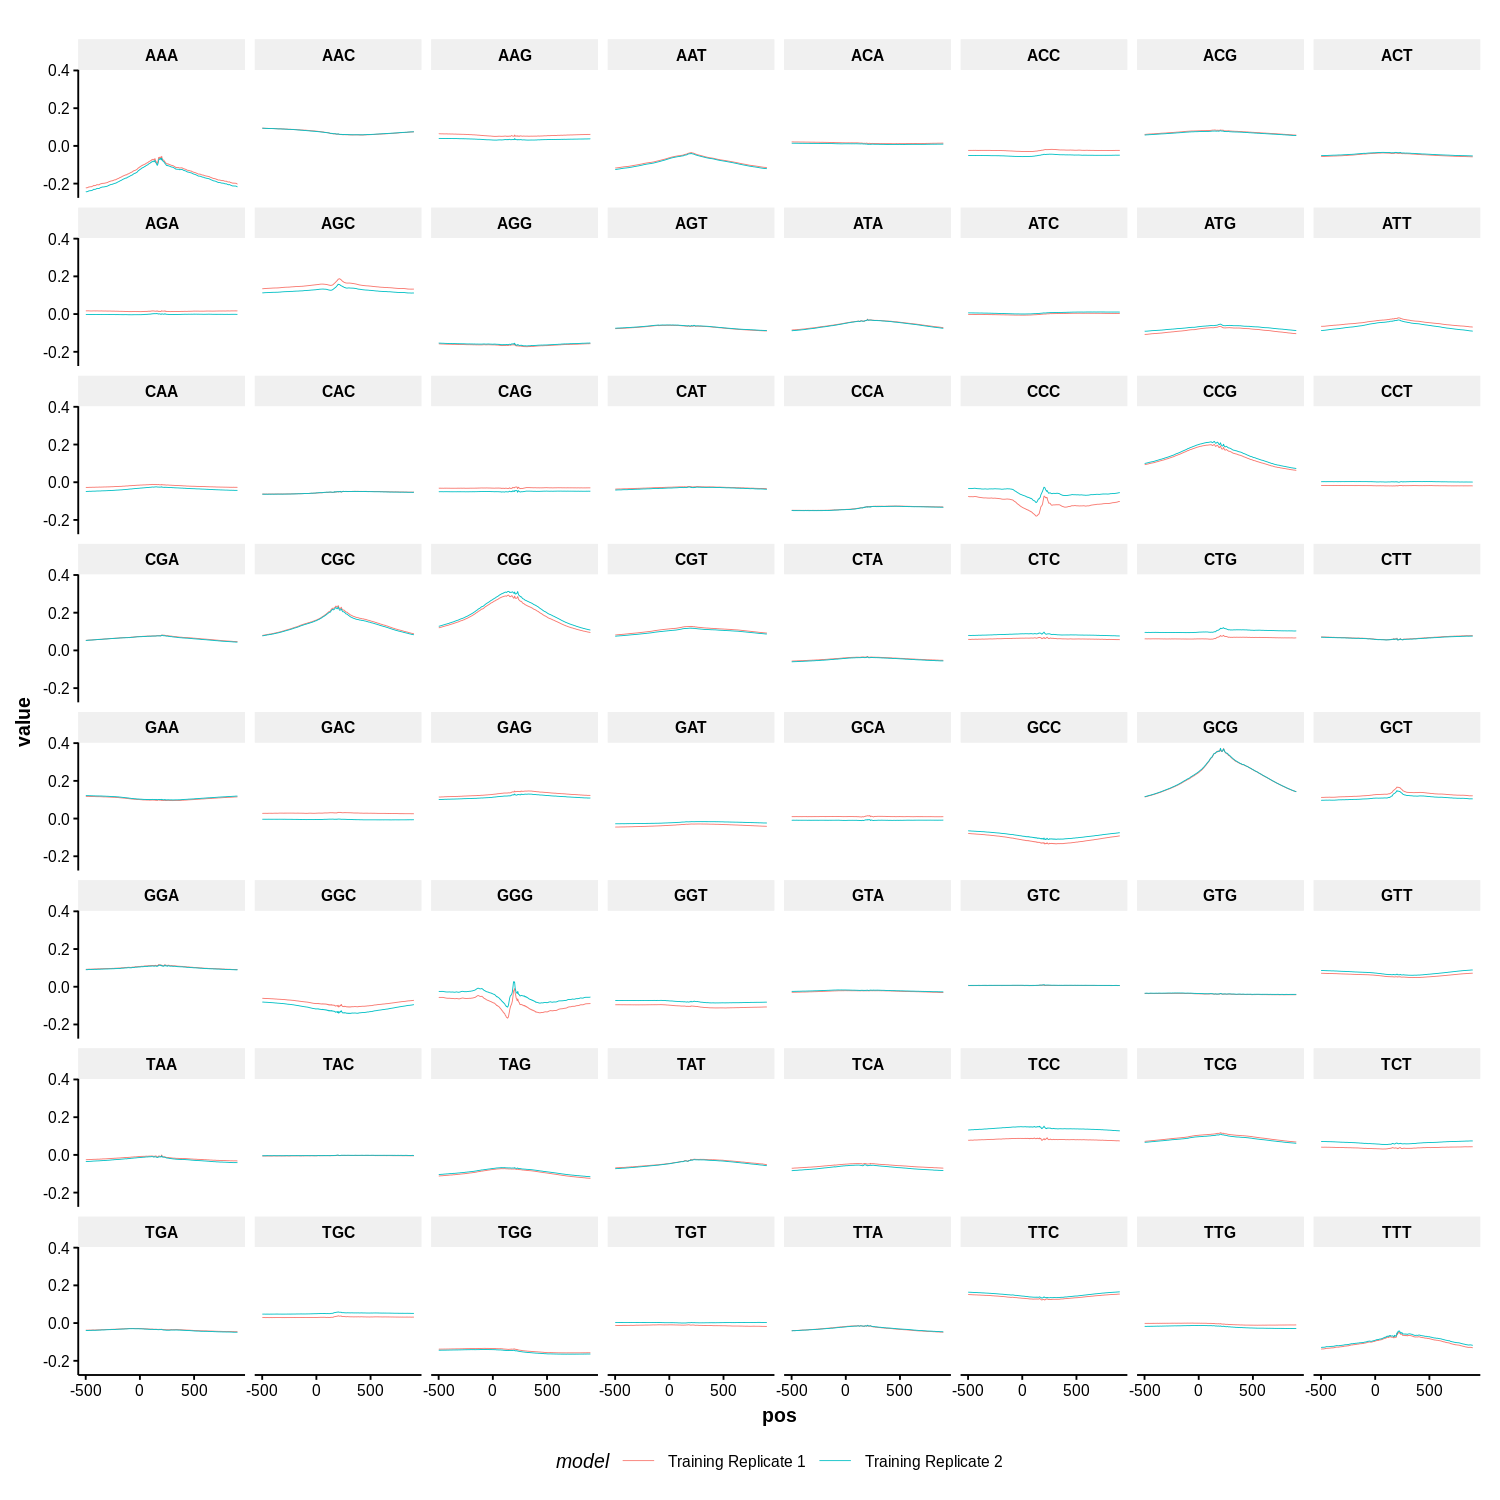

In [ ]:
%%R -i tri_list,convolved_array_rep0,convolved_array_rep1  -w 15 -h 15 --unit in --res 100
require(ggplot2)
require(data.table)
plotdata = data.frame(convolved_array_rep0)
plotdata$tri = unlist(tri_list)
plotdata = melt(plotdata,id='tri')
plotdata$pos = as.numeric(gsub('X','',as.character(plotdata$variable)))
plotdata=data.table(plotdata)
plotdata$model="Training Replicate 1"

plotdata1 = data.frame(convolved_array_rep1)
plotdata1$tri = unlist(tri_list)
plotdata1 = melt(plotdata1,id='tri')
plotdata1$pos = as.numeric(gsub('X','',as.character(plotdata1$variable)))
plotdata1=data.table(plotdata1)
plotdata1$model="Training Replicate 2"

plotdata = rbind(plotdata, plotdata1)
p = ggplot(plotdata[,pos:=pos-500,])+
    geom_line(aes(x=pos, y=value, color=model),size=I(0.3))+facet_wrap(~tri)+theme_Publication()
ggsave('./figures/tri_distxeffects.rep.pdf', device=cairo_pdf)
p

R[write to console]: Saving 15 x 15 in image



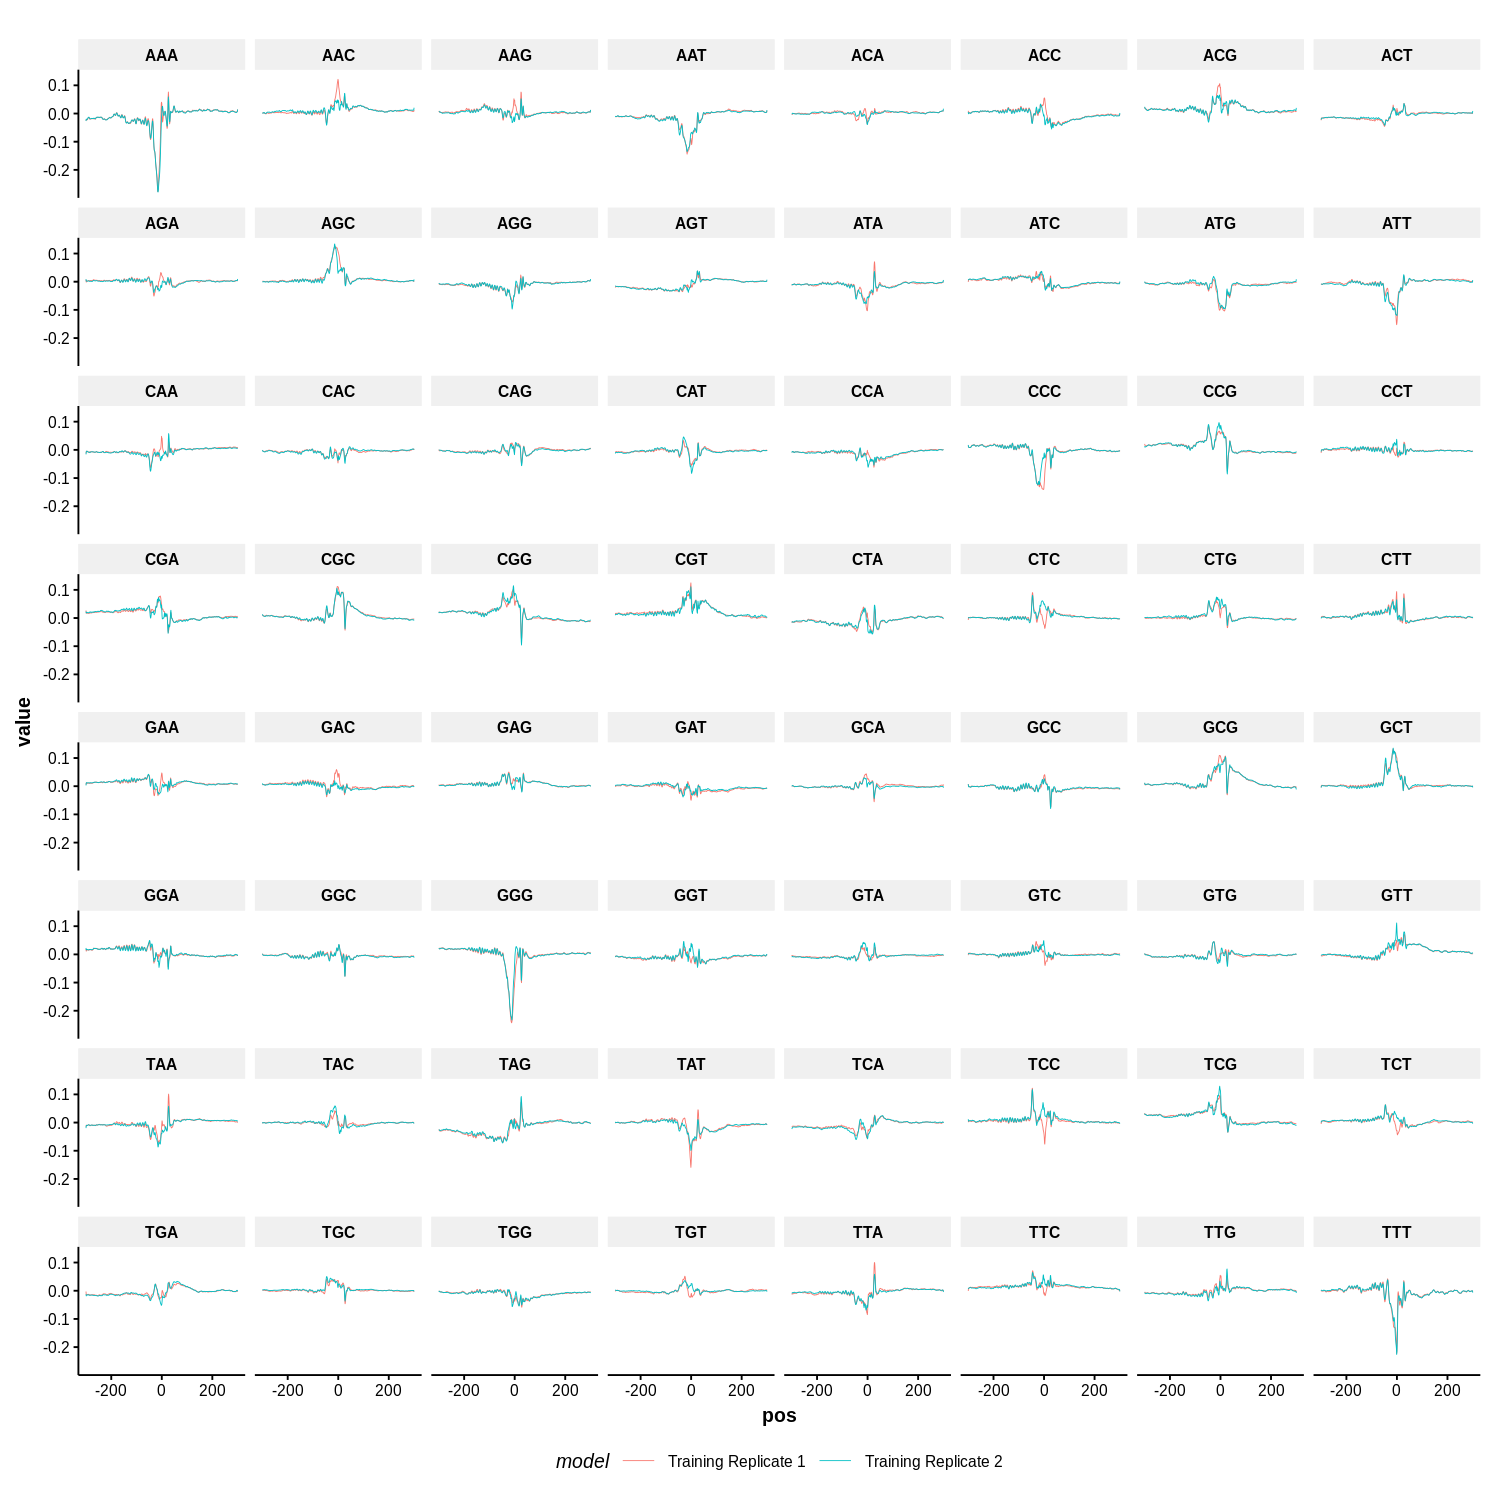

In [ ]:
%%R -i tri_list,tri_effects_rep0,tri_effects_rep1  -w 15 -h 15 --unit in --res 100
require(ggplot2)
require(data.table)
plotdata = data.frame(tri_effects_rep0)
plotdata$tri = unlist(tri_list)
plotdata = melt(plotdata,id='tri')
plotdata$pos = as.numeric(gsub('X','',as.character(plotdata$variable)))
plotdata=data.table(plotdata)
plotdata$model="Training Replicate 1"

plotdata1 = data.frame(tri_effects_rep1)
plotdata1$tri = unlist(tri_list)
plotdata1 = melt(plotdata1,id='tri')
plotdata1$pos = as.numeric(gsub('X','',as.character(plotdata1$variable)))
plotdata1=data.table(plotdata1)
plotdata1$model="Training Replicate 2"

plotdata = rbind(plotdata, plotdata1)


p = ggplot(plotdata[,pos:=pos-301,])+
    geom_line(aes(x=pos, y=value, color=model),size=I(0.3))+facet_wrap(~tri)+theme_Publication()

ggsave('./figures/tri_effects.rep.pdf', device=cairo_pdf)
p